<a href="https://colab.research.google.com/github/AftabUdaipurwala/Deeplearning/blob/main/Distributed_Training_on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import cv2
import pandas as pd
import numpy as np
from sklearn import linear_model
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(20,10)
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import PIL
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models


In [9]:
!nvidia-smi

Mon Dec  6 02:28:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
!ls '/content/drive/MyDrive/py-master/DeepLearningML/16_cnn_cifar10_small_image_classification/'

ls: cannot access '/content/drive/MyDrive/py-master/DeepLearningML/16_cnn_cifar10_small_image_classification/': No such file or directory


In [11]:
(xtrain, ytrain), (xtest, ytest) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [22]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
xtrain.shape

(50000, 32, 32, 3)

In [13]:
xtest.shape

(10000, 32, 32, 3)

In [14]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [15]:
ytest = ytest.reshape(-1,)
ytest[:5]

array([3, 8, 8, 0, 6], dtype=uint8)

In [16]:
ytrain = ytrain.reshape(-1,)
ytrain[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [17]:
def plot_sample(x,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]])


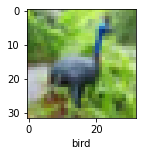

In [18]:
plot_sample(xtrain,ytrain,6)

In [19]:
xtrain = xtrain/255 # scaling the pics to make it easier for computer to process
xtest = xtest/255

In [26]:
ytrain_categorical = keras.utils.to_categorical(ytrain,num_classes=10,dtype='float32')
ytest_categorical = keras.utils.to_categorical(ytest,num_classes=10,dtype='float32') # converting training & testing to categorical variable to make tf dataset

In [23]:
def get_model():
  model= keras.Sequential([
                           keras.layers.Flatten(input_shape=(32,32,3)),
                           keras.layers.Dense(3000, activation='relu'),
                           keras.layers.Dense(1000, activation ='relu'),
                           keras.layers.Dense(10,activation='sigmoid')
  ])
  model.compile(optimizer ='adam', loss ='categorical_crossentropy',metrics=['accuracy'])
  return model

In [28]:
train_tf_dataset = tf.data.Dataset.from_tensor_slices((xtrain,ytrain_categorical))
test_tf_dataset = tf.data.Dataset.from_tensor_slices((xtest,ytest_categorical))

In [29]:
strategy = tf.distribute.MirroredStrategy()
strategy.num_replicas_in_sync # since i am using only 1 gpu on colab hence not having more than 1 mirrors

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


1

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Creating batches for running the models

Batch_size_per_replica=250
Batch_size =Batch_size_per_replica*strategy.num_replicas_in_sync
train_batch= train_tf_dataset.batch(Batch_size).prefetch(tf.data.AUTOTUNE)
test_batch= test_tf_dataset.batch(Batch_size)

In [35]:
%%timeit -n1 -r1
with strategy.scope():
  gpu_model=get_model()
  gpu_model.fit(train_batch,epochs=50)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
200/200 [==============================] - 6s 18ms/step - loss: 2.1934 - accuracy: 0.2867
Epoch 2/50
200/200 [==============================] - 4s 18

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
ypred = gpu_model.predict(test_batch)
ypred_classes = [np.argmax(element) for element in ypred]
print(classification_report(ytest, ypred_classes))

              precision    recall  f1-score   support

           0       0.58      0.57      0.57      1000
           1       0.58      0.67      0.62      1000
           2       0.39      0.40      0.39      1000
           3       0.34      0.28      0.31      1000
           4       0.41      0.40      0.40      1000
           5       0.40      0.39      0.40      1000
           6       0.52      0.54      0.53      1000
           7       0.57      0.55      0.56      1000
           8       0.63      0.60      0.61      1000
           9       0.53      0.56      0.55      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000

